# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

## Lab Class #4 - Bundle Adjustment

---
#**Personal Info:**
*   **Student:**
    *   Sherlon Almeida da Silva
*   **Affiliation:**
    *   PhD Student
    *   University of São Paulo (USP)
    *   Institute of Mathematics and Computer Science (ICMC)
    *   Laboratory of Visualization, Imaging and Computer Graphics (VICG)
*   **Research & Programming:**
    *   [Lattes](http://lattes.cnpq.br/0000096258045504) | [ORCID](https://orcid.org/0000-0001-6124-9350) | [Google Scholar](https://scholar.google.com.br/citations?user=boFxo4gAAAAJ&hl=pt-BR) | [Linkedin](https://www.linkedin.com/in/SherlonAlmeida/) | [Github](https://github.com/SherlonAlmeida) | [Personal Page](http://vicg.icmc.usp.br/vicg/person/72/sherlon-almeida-da-silva)
---

# Absolute camera orientation given set of relative camera pairs

The problem we deal with is defined as follows:

Given an optical system of $N$ cameras with extrinsics $\{g_1, ..., g_N | g_i \in SE(3)\}$, and a set of relative camera positions $\{g_{ij} | g_{ij}\in SE(3)\}$ that map between coordinate frames of randomly selected pairs of cameras $(i, j)$, we search for the absolute extrinsic parameters $\{g_1, ..., g_N\}$ that are consistent with the relative camera motions.

More formally:
$$
g_1, ..., g_N = 
{\arg \min}_{g_1, ..., g_N} \sum_{g_{ij}} d(g_{ij}, g_i^{-1} g_j),
$$,
where $d(g_i, g_j)$ is a suitable metric that compares the extrinsics of cameras $g_i$ and $g_j$. 

Visually, the problem can be described as follows. The picture below depicts the situation at the beginning of our optimization. The ground truth cameras are plotted in purple while the randomly initialized estimated cameras are plotted in orange:


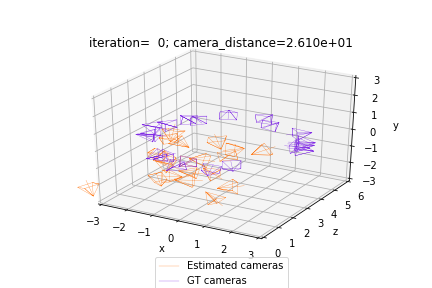

Our optimization seeks to align the estimated (orange) cameras with the ground truth (purple) cameras, by minimizing the discrepancies between pairs of relative cameras. Thus, the solution to the problem should look as follows:

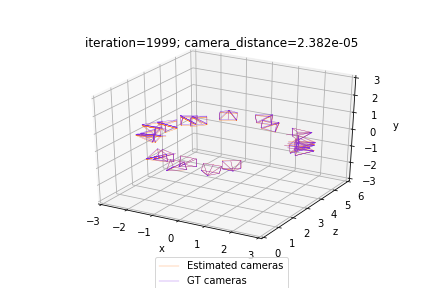

In practice, the camera extrinsics $g_{ij}$ and $g_i$ are represented using objects from the `PerspectiveCameras` class initialized with the corresponding rotation and translation matrices `R_absolute` and `T_absolute` that define the extrinsic parameters $g = (R, T); R \in SO(3); T \in \mathbb{R}^3$. In order to ensure that `R_absolute` is a valid rotation matrix, we represent it using an exponential map (implemented with `so3_exponential_map`) of the axis-angle representation of the rotation `log_R_absolute`.

## 0. Install and Import Modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
# imports
import matplotlib.pyplot as plt
import torch
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
from pytorch3d.renderer.cameras import (
    PerspectiveCameras,
)

from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    RasterizationSettings, PointLights, MeshRenderer, 
    MeshRasterizer, SoftPhongShader
)

# add path for demo utils
import sys
import os
sys.path.append(os.path.abspath(''))

# set for reproducibility
torch.manual_seed(777)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

If using **Google Colab**, fetch the utils file for plotting the camera scene, and the ground truth camera positions:

In [3]:
!wget https://raw.githubusercontent.com/hallpaz/3dsystems23/master/scripts/camera_visualization.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from camera_visualization import plot_camera_scene
from plot_image_grid import image_grid

!mkdir data
!wget -P data https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/data/camera_graph.pth

--2023-04-27 02:50:47--  https://raw.githubusercontent.com/hallpaz/3dsystems23/master/scripts/camera_visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2178 (2.1K) [text/plain]
Saving to: ‘camera_visualization.py.4’

camera_visualizatio 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-04-27 02:50:47 (43.3 MB/s) - ‘camera_visualization.py.4’ saved [2178/2178]

--2023-04-27 02:50:47--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent

OR if running **locally** uncomment and run the following cell:

In [4]:
# from utils import plot_camera_scene
# from utils import image_grid

## 1. Set up Cameras and load ground truth positions

In [5]:
# load the SE3 graph of relative/absolute camera positions
camera_graph_file = './data/camera_graph.pth'
(R_absolute_gt, T_absolute_gt), \
    (R_relative, T_relative), \
    relative_edges = \
        torch.load(camera_graph_file)

# create the relative cameras
cameras_relative = PerspectiveCameras(
    R = R_relative.to(device),
    T = T_relative.to(device),
    device = device,
)

# create the absolute ground truth cameras
cameras_absolute_gt = PerspectiveCameras(
    R = R_absolute_gt.to(device),
    T = T_absolute_gt.to(device),
    device = device,
)

# the number of absolute camera positions
N = R_absolute_gt.shape[0]
print(f"Number of cameras: {N}")

Number of cameras: 20


1.1 Check the ground truth values for rotation and translation of the first camera $g_0$. Do they look like measured values or arbitrary ones? Why do you think this decision was taken?

In [6]:
##############################################################################
# Code and explanation for 1.1
##############################################################################
idx = 0
R_absolute_gt[idx], T_absolute_gt[idx]

(tensor([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]),
 tensor([-0., -0., -0.]))

### **Considerations:**
Since the given rotation matrix is the identity matrix and the translation matrix contains only zeros, this suggests that the camera is positioned at the origin of the coordinate system and is not rotated. It is possible that these values were chosen arbitrarily as an initial reference pose for the camera. Using a reference position centered at the origin can be useful to define the position of the other cameras.

## 2. Define optimization functions

### Relative cameras and camera distance
We now define two functions crucial for the optimization.

**`calc_camera_distance`** compares a pair of cameras. This function is important as it defines the loss that we are minimizing. The method utilizes the `so3_relative_angle` function from the SO3 API.

**`get_relative_camera`** computes the parameters of a relative camera that maps between a pair of absolute cameras. Here we utilize the `compose` and `inverse` class methods from the PyTorch3D Transforms API.

In [7]:
def calc_camera_distance(cam_1, cam_2):
    """
    Calculates the divergence of a batch of pairs of cameras cam_1, cam_2.
    The distance is composed of the cosine of the relative angle between 
    the rotation components of the camera extrinsics and the L2 distance
    between the translation vectors.
    """
    # rotation distance
    R_distance = (1.-so3_relative_angle(cam_1.R, cam_2.R, cos_angle=True)).mean()
    # translation distance
    T_distance = ((cam_1.T - cam_2.T)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance

def get_relative_camera(cams, edges):
    """
    For each pair of indices (i,j) in "edges" generate a camera
    that maps from the coordinates of the camera cams[i] to 
    the coordinates of the camera cams[j]
    """

    # first generate the world-to-view Transform3d objects of each 
    # camera pair (i, j) according to the edges argument
    trans_i, trans_j = [
        PerspectiveCameras(
            R = cams.R[edges[:, i]],
            T = cams.T[edges[:, i]],
            device = device,
        ).get_world_to_view_transform()
         for i in (0, 1)
    ]
    
    # compose the relative transformation as g_i^{-1} g_j
    trans_rel = trans_i.inverse().compose(trans_j)
    
    # generate a camera from the relative transform
    matrix_rel = trans_rel.get_matrix()
    cams_relative = PerspectiveCameras(
                        R = matrix_rel[:, :3, :3],
                        T = matrix_rel[:, 3, :3],
                        device = device,
                    )
    return cams_relative

2.1 In this task, we are parameterizing the 3D rotation group - $SO(3)$ - using rotation matrices. This choice has some drawbacks, as we need to ensure our matrices are valid rotation matrices. Which other choice(s) could we have used to parameterize rotations? Would it be a better choice?

In [8]:
##############################################################################
# Explanation for 2.1
##############################################################################

### **Considerations:**
There are several alternative methods for parameterizing rotations besides rotation matrices, and the choice depends on the specific requirements of the application. Euler angles represent rotations as a sequence of three angles, but may be less numerically stable than other representations. Quaternions are more computationally efficient but may be less intuitive to work with. The axis-angle representation is straightforward, but requires additional computational overhead. The Lie algebra representation can be more numerically stable and useful for optimization problems but requires additional mathematical knowledge. Each representation has its own advantages and drawbacks, and it is important to choose the one that best suits the requirements of the problem at hand.

## 3. Optimization
Finally, we start the optimization of the absolute cameras.

We use SGD with momentum and optimize over `log_R_absolute` and `T_absolute`. 

As mentioned earlier, `log_R_absolute` is the axis angle representation of the rotation part of our absolute cameras. We can obtain the 3x3 rotation matrix `R_absolute` that corresponds to `log_R_absolute` with:

`R_absolute = so3_exponential_map(log_R_absolute)`


3.1. Download the *cow mesh* and user the function `render_scene` (below) to render it using the cameras of the ground truth. Do the same using the initial values of the estimated cameras. 

*You don't need to understand how to set up a renderer now, we'll cover this later on the couser. For now, just focus on analyzing the results.*

In [9]:
# download the cow mesh
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2023-04-27 02:50:51--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.33, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj.4’

cow.obj.4           100%[===================>] 322.91K  --.-KB/s    in 0.01s   

2023-04-27 02:50:51 (21.0 MB/s) - ‘data/cow_mesh/cow.obj.4’ saved [330659/330659]

--2023-04-27 02:50:51--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.33, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl.4’

cow.mtl.4           

In [10]:
def render_scene(meshes, cameras, device):
  """
  Renders 3D meshes to a tensor of images.

  Args:
    meshes: a Meshes instance holding the meshes to be rendered
    cameras: a pytorch3D Cameras instance such as PerspectiveCameras
    device: a torch.device

  """
  if len(meshes) != len(cameras):
    meshes = meshes.extend(len(cameras))

  raster_settings = RasterizationSettings(
      image_size=512, 
      blur_radius=0.0, 
      faces_per_pixel=1, 
  )
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
  renderer = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=cameras, 
          raster_settings=raster_settings
      ),
      shader=SoftPhongShader(
          device=device, 
          cameras=cameras,
          lights=lights
      )
  )
  return renderer(meshes).detach()

In [11]:
##############################################################################
# Code for 3.1
##############################################################################

In [12]:
from pytorch3d.io import load_obj
import matplotlib.pyplot as plt
from pytorch3d.renderer import Textures

obj_file = "data/cow_mesh/cow.obj"
meshes = load_objs_as_meshes([obj_file]).to('cuda' if torch.cuda.is_available() else 'cpu')

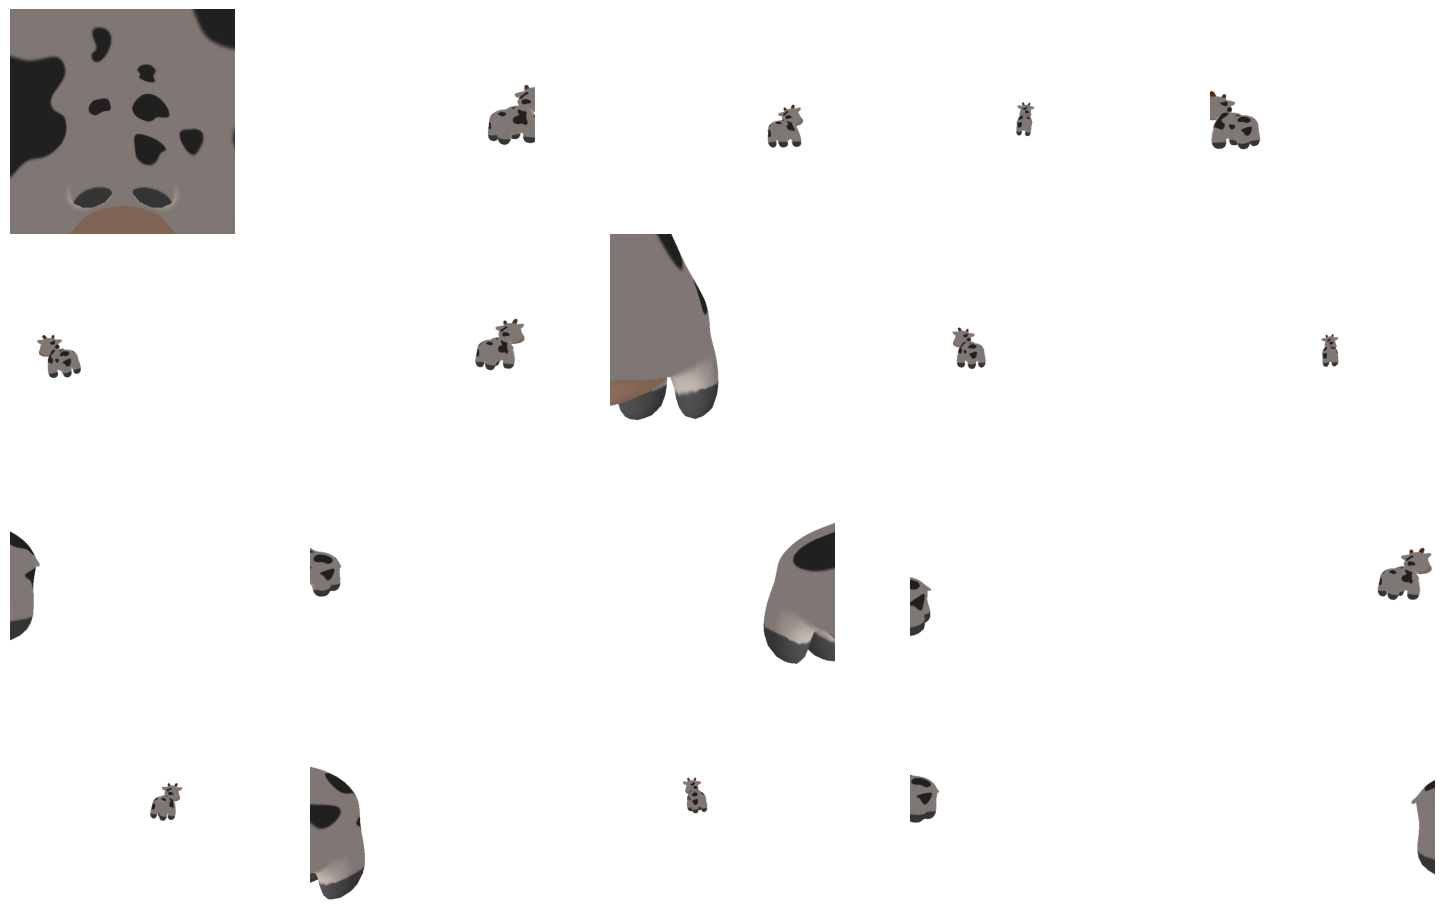

In [13]:
#Using the ground truth cameras
cameras = cameras_absolute_gt

# you can visualize the images using the image_grid function:
images_gt = render_scene(meshes, cameras, device)
image_grid(images_gt.cpu().numpy(), rows=4, cols=5, rgb=True)

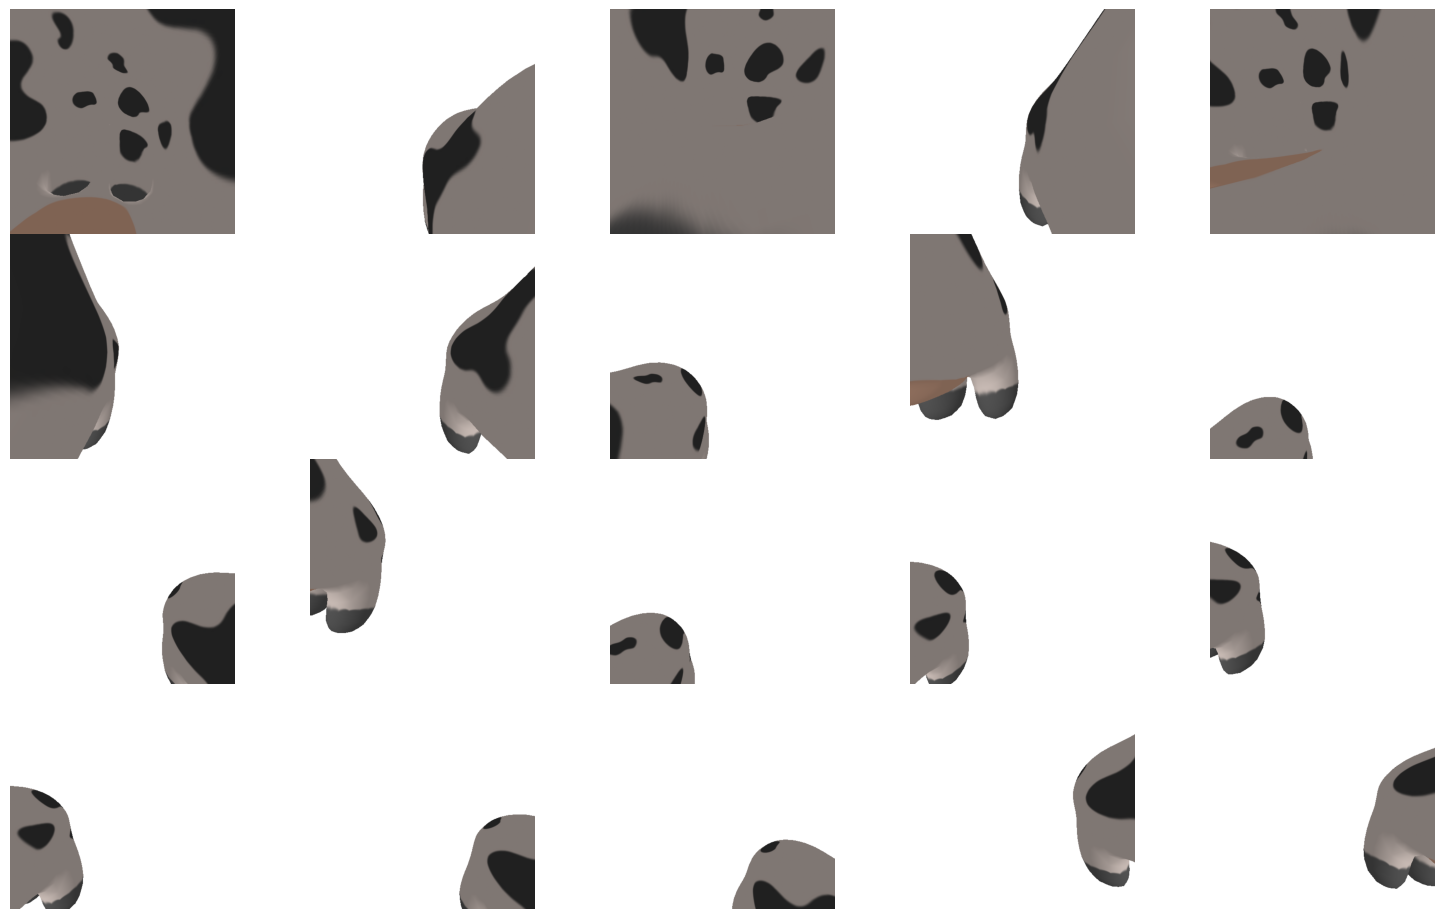

In [14]:
#Using the relative cameras
cameras = cameras_relative

# you can visualize the images using the image_grid function:
images_r = render_scene(meshes, cameras, device)
image_grid(images_r.cpu().numpy(), rows=4, cols=5, rgb=True)

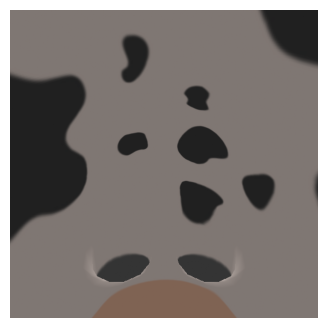

In [15]:
# or you can choose a single image to check with matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(images_gt[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

###**Considerations:**
The ground truth cameras captured more distant images, whilst relative cameras are closer to the 3D object in the scene.

3.2 Run the optimization loop and plot the  *loss vs iteration* graph. 

**[Extra] E.1: Can you do better (improve the approximation)?**

In [16]:
##############################################################################
# Code and explanation for 3.2 (and extras)
##############################################################################

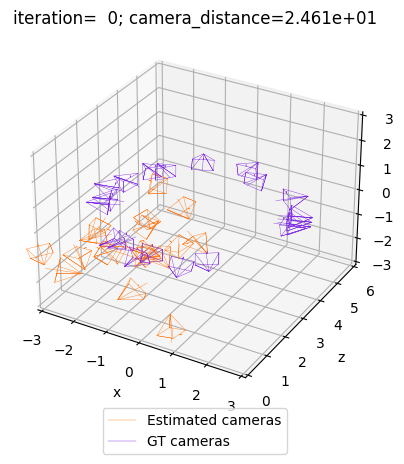

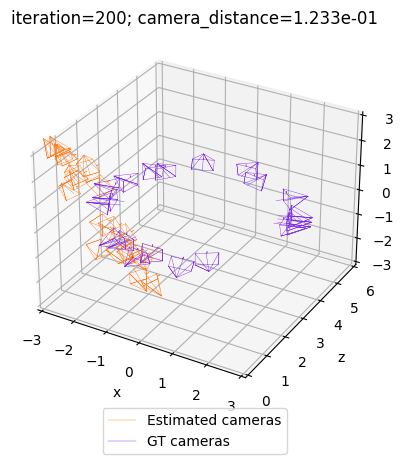

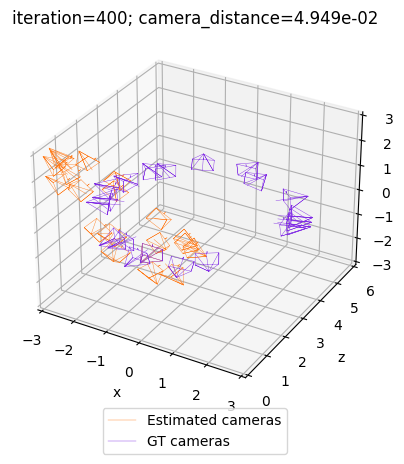

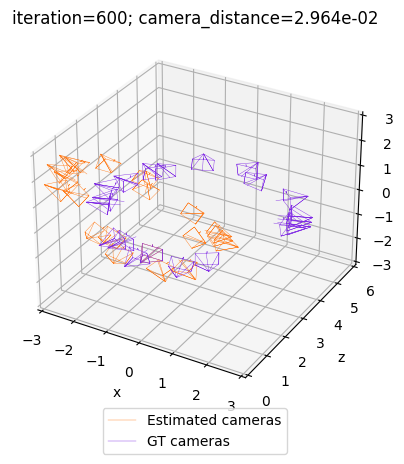

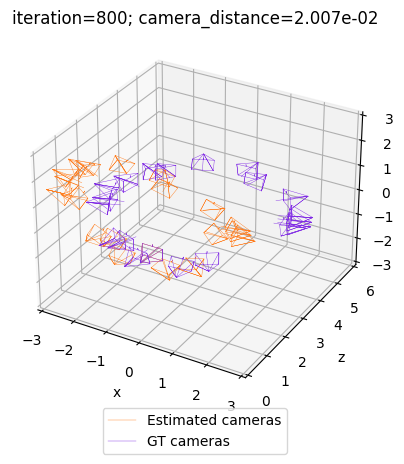

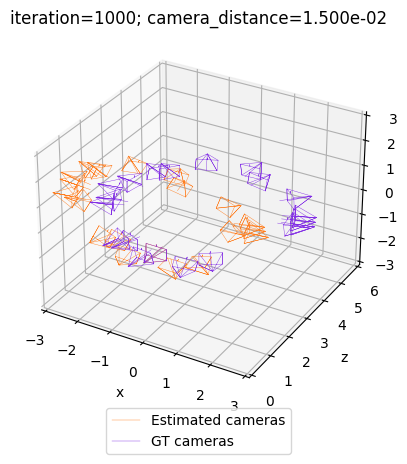

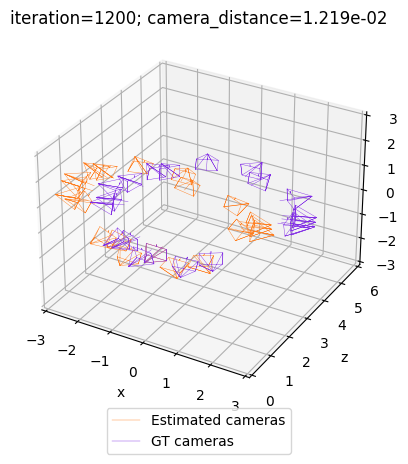

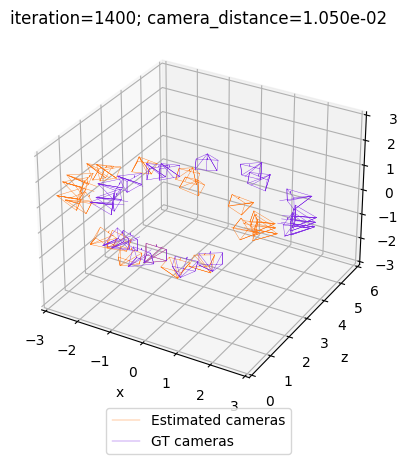

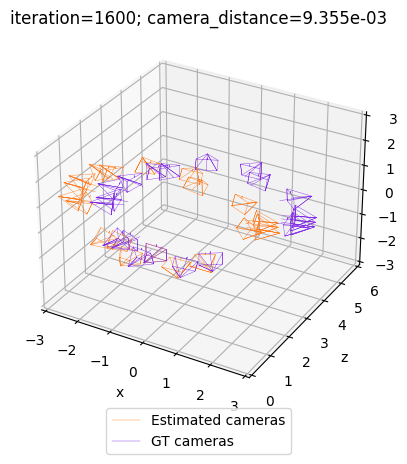

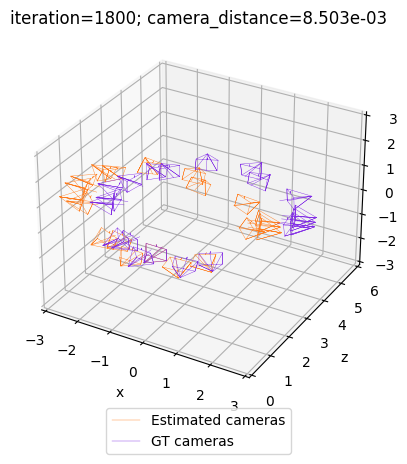

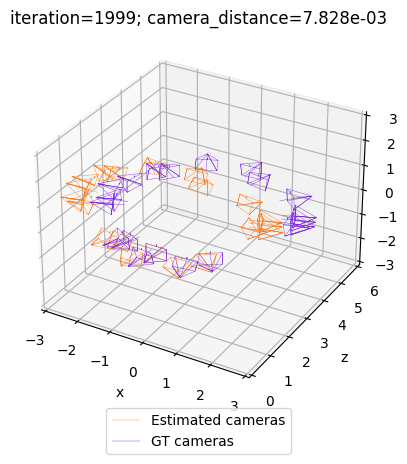

Optimization finished.


In [17]:
# initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one 
# (check exercise 1.1 above)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
log_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct, 
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=.1, momentum=0.9)

# Sherlon: Store the loss
loss_over_iteration = []

# run the optimization
n_iter = 2000  # fix the number of iterations
for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as 
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = so3_exponential_map(log_R_absolute * camera_mask)

    # get the current absolute cameras
    cameras_absolute = PerspectiveCameras(
        R = R_absolute,
        T = T_absolute * camera_mask,
        device = device,
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # our loss function is the camera_distance
    camera_distance.backward()
    
    # apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 200==0 or it==n_iter-1:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)
    
    loss_over_iteration.append(camera_distance)

print('Optimization finished.')


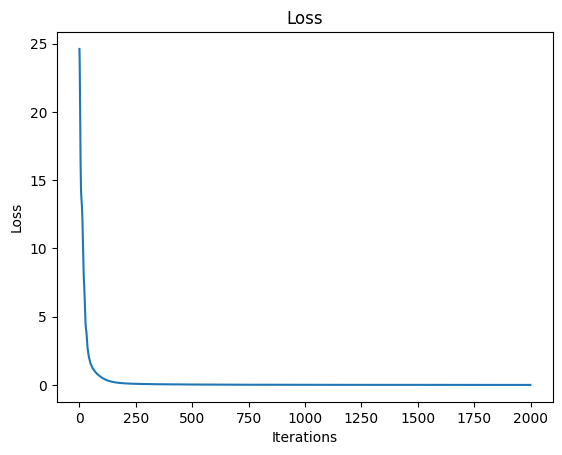

In [18]:
import matplotlib.pyplot as plt

# example loss data
loss_data = [loss_over_iteration[i].item() for i in range(len(loss_over_iteration))]

# plot the loss data as a line
plt.plot(loss_data)

# set the x and y axis labels
plt.xlabel('Iterations')
plt.ylabel('Loss')

# set the title of the plot
plt.title('Loss')

# show the plot
plt.show()


###**Considerations:**
As can be seen, the figures above demonstrate the approximation of the orange (relative) cameras to the purple (ground truth) cameras.

3.3 Render the images again, now using the ground truth cameras and the optimized cameras. Describe the results qualitatively.

**[Extra] E.2: Use another representation for rotation matrices to solve the bundle adjustment problem.**

In [19]:
##############################################################################
# Code and explanation for 3.3 (and extras)
##############################################################################

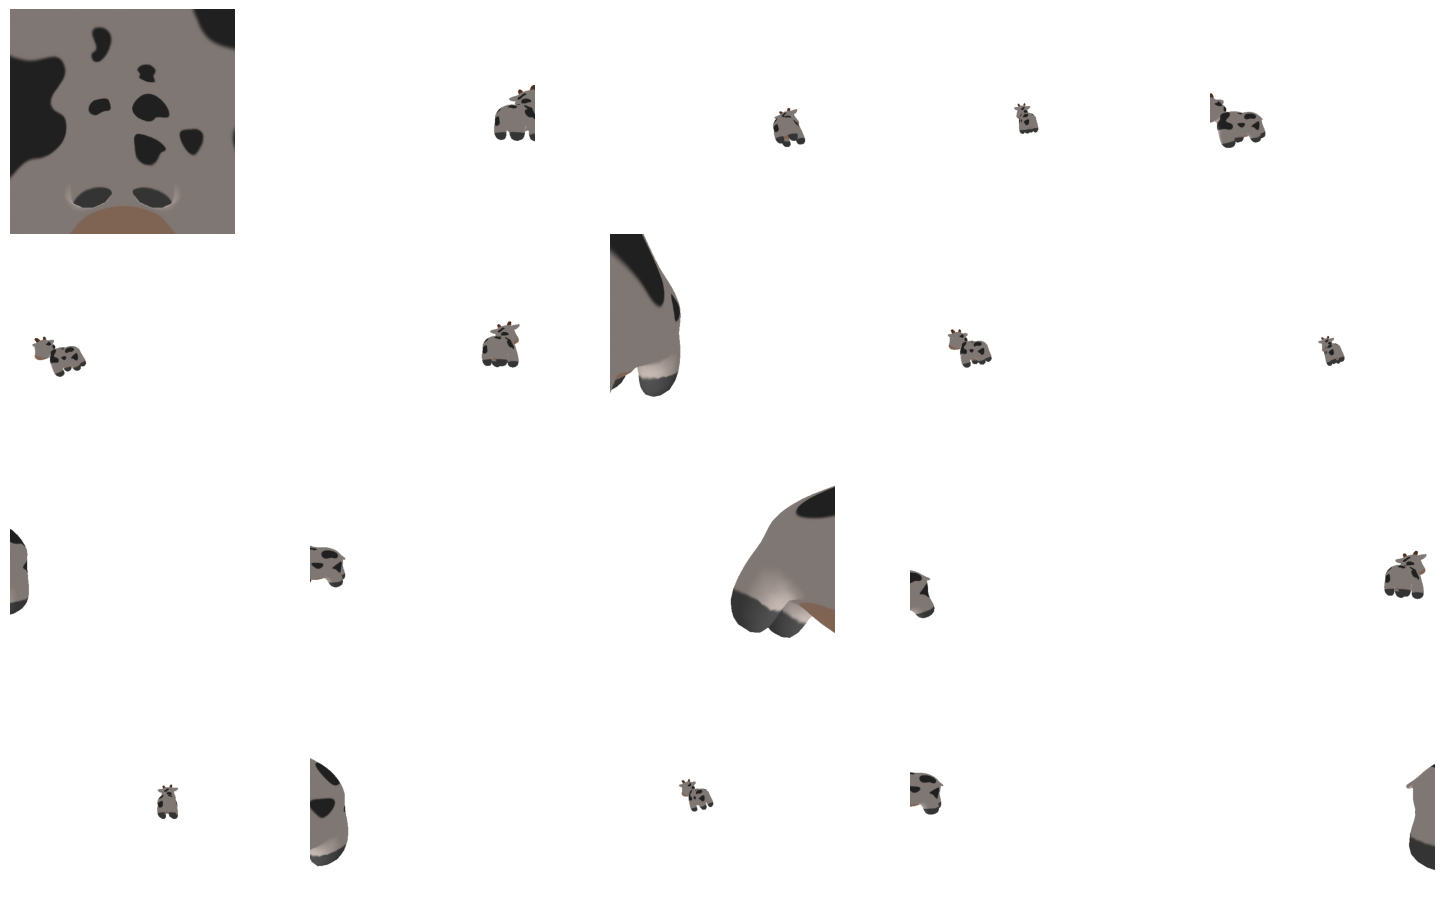

In [20]:
#Using the optimized cameras (Approximation)
cameras = cameras_absolute

# you can visualize the images using the image_grid function:
images_ap = render_scene(meshes, cameras, device)
image_grid(images_ap.cpu().numpy(), rows=4, cols=5, rgb=True)

###**Considerations:**
The optimized cameras indicate that the loss function and optimizer have produced good representations by showing the object to be more centralized than the initial relative cameras and approximating the ground truth. To further improve the results, it may be worth considering other parameters in the loss function or using a better optimizer.